In [1]:
import os
# Ignore Tensorflow Warnings
os.environ["TF_CPP_MIN_LOG_LEVEL"] = '2'

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import tensorflow as tf
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)
import numpy as np

import pandas as pd
from keras.models import load_model
from datetime import datetime, timedelta
from scipy import interpolate
from matplotlib.gridspec import GridSpec

%matplotlib widget

# General Model Information
Change nmin and nmax to plot the time series over a certain time period. nmin = 8761, nmax = 17496 corresponds to the whole year of the test data. 

In [2]:
# Define how many and which data points should be displayed
nmin = 8761#11400 - 7*24
nmax = 17496#11400 + 7*24 # The two weeks around the data point in the main plot

In [3]:
# Model information (used later for image output)
model_dates = ["20220307", "20220307", "20220308"]
kernel = 16

# Define the date range of the whole simulation
start_date = datetime(2018, 1, 1, 0, 0)
end_date = datetime(2019, 12, 31, 23, 0)

# Define time_step and time_step_type of the simulation
time_step_type = "hrs"
time_step = 1

# Define the range of the time series
variables = ["Hs", "Tm02", "Dir"]
sample_start = 8761 # Start of test data
sample_end = 17496 # Maximum data point

sample_train_start = 24
sample_train_end = 8760

# Save the figure?
save = False
convert = True

# Helper Function

In [4]:
# Define help function to create a generator that outputs a datetime object for the given time range (always needed)
if time_step_type == "hrs":
    const = int(24/time_step)
    
    def daterange(start_date, end_date):
        for n in range(const*int((end_date - start_date).days)):
            yield start_date + n*timedelta(hours=time_step)

else:
    const = int(60/time_step * 24)
    
    def daterange(start_date, end_date):
        for n in range(const*int((end_date - start_date).days)):
            yield start_date + n*timedelta(minutes=time_step)         

# Load the Data

In [5]:
# Load all the dates
# Get whole date range
dates = []
for date in daterange(start_date, end_date):
    dates.append(date)

# Load best models into list
best_models = []
for i in range(len(model_dates)):
    fmodel = "Models/Weights_{}_{}.hdf5"
    fmodel = fmodel.format(variables[i], model_dates[i]) 
    best_models.append(load_model(fmodel))


prediction = []
reference = []
LR_reference = []
ref_training = []

# Load the LR and HR images
for i, var in enumerate(variables):
    # Load saved array, if calculation was already done before
    path_dir = "./Data/TimeSeries"
    path_arr = path_dir + "/{}_TimeSeries.csv".format(var)
    
    path_arr_train = path_dir + "/Ref_{}_TimeSeries.csv".format(var)
    
    arr = np.loadtxt(path_arr, delimiter=",")
    arr_train = np.loadtxt(path_arr_train, delimiter=",")
    
    prediction.append(arr[0,:])
    reference.append(arr[1,:])
    LR_reference.append(arr[2,:])
    ref_training.append(arr_train)

# Compute MSEs and Error

In [6]:
mse = []
mse_LR = []
#mse_int = []

for i in range(len(variables)):
    mse.append(np.nanmean((reference[i] - prediction[i])**2))
    mse_LR.append(np.nanmean((reference[i] - LR_reference[i])**2))
    #mse_int.append(((reference[i] - int_arr[i])**2).mean())

In [7]:
error = []
error_LR = []
for i in range(len(prediction)):
    error.append(100*np.abs(reference[i] - prediction[i])/reference[i])
    error_LR.append(100*np.abs(reference[i] - LR_reference[i])/reference[i])

# Plot all variables

/tmp/ipykernel_9984/59720162.py:200: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
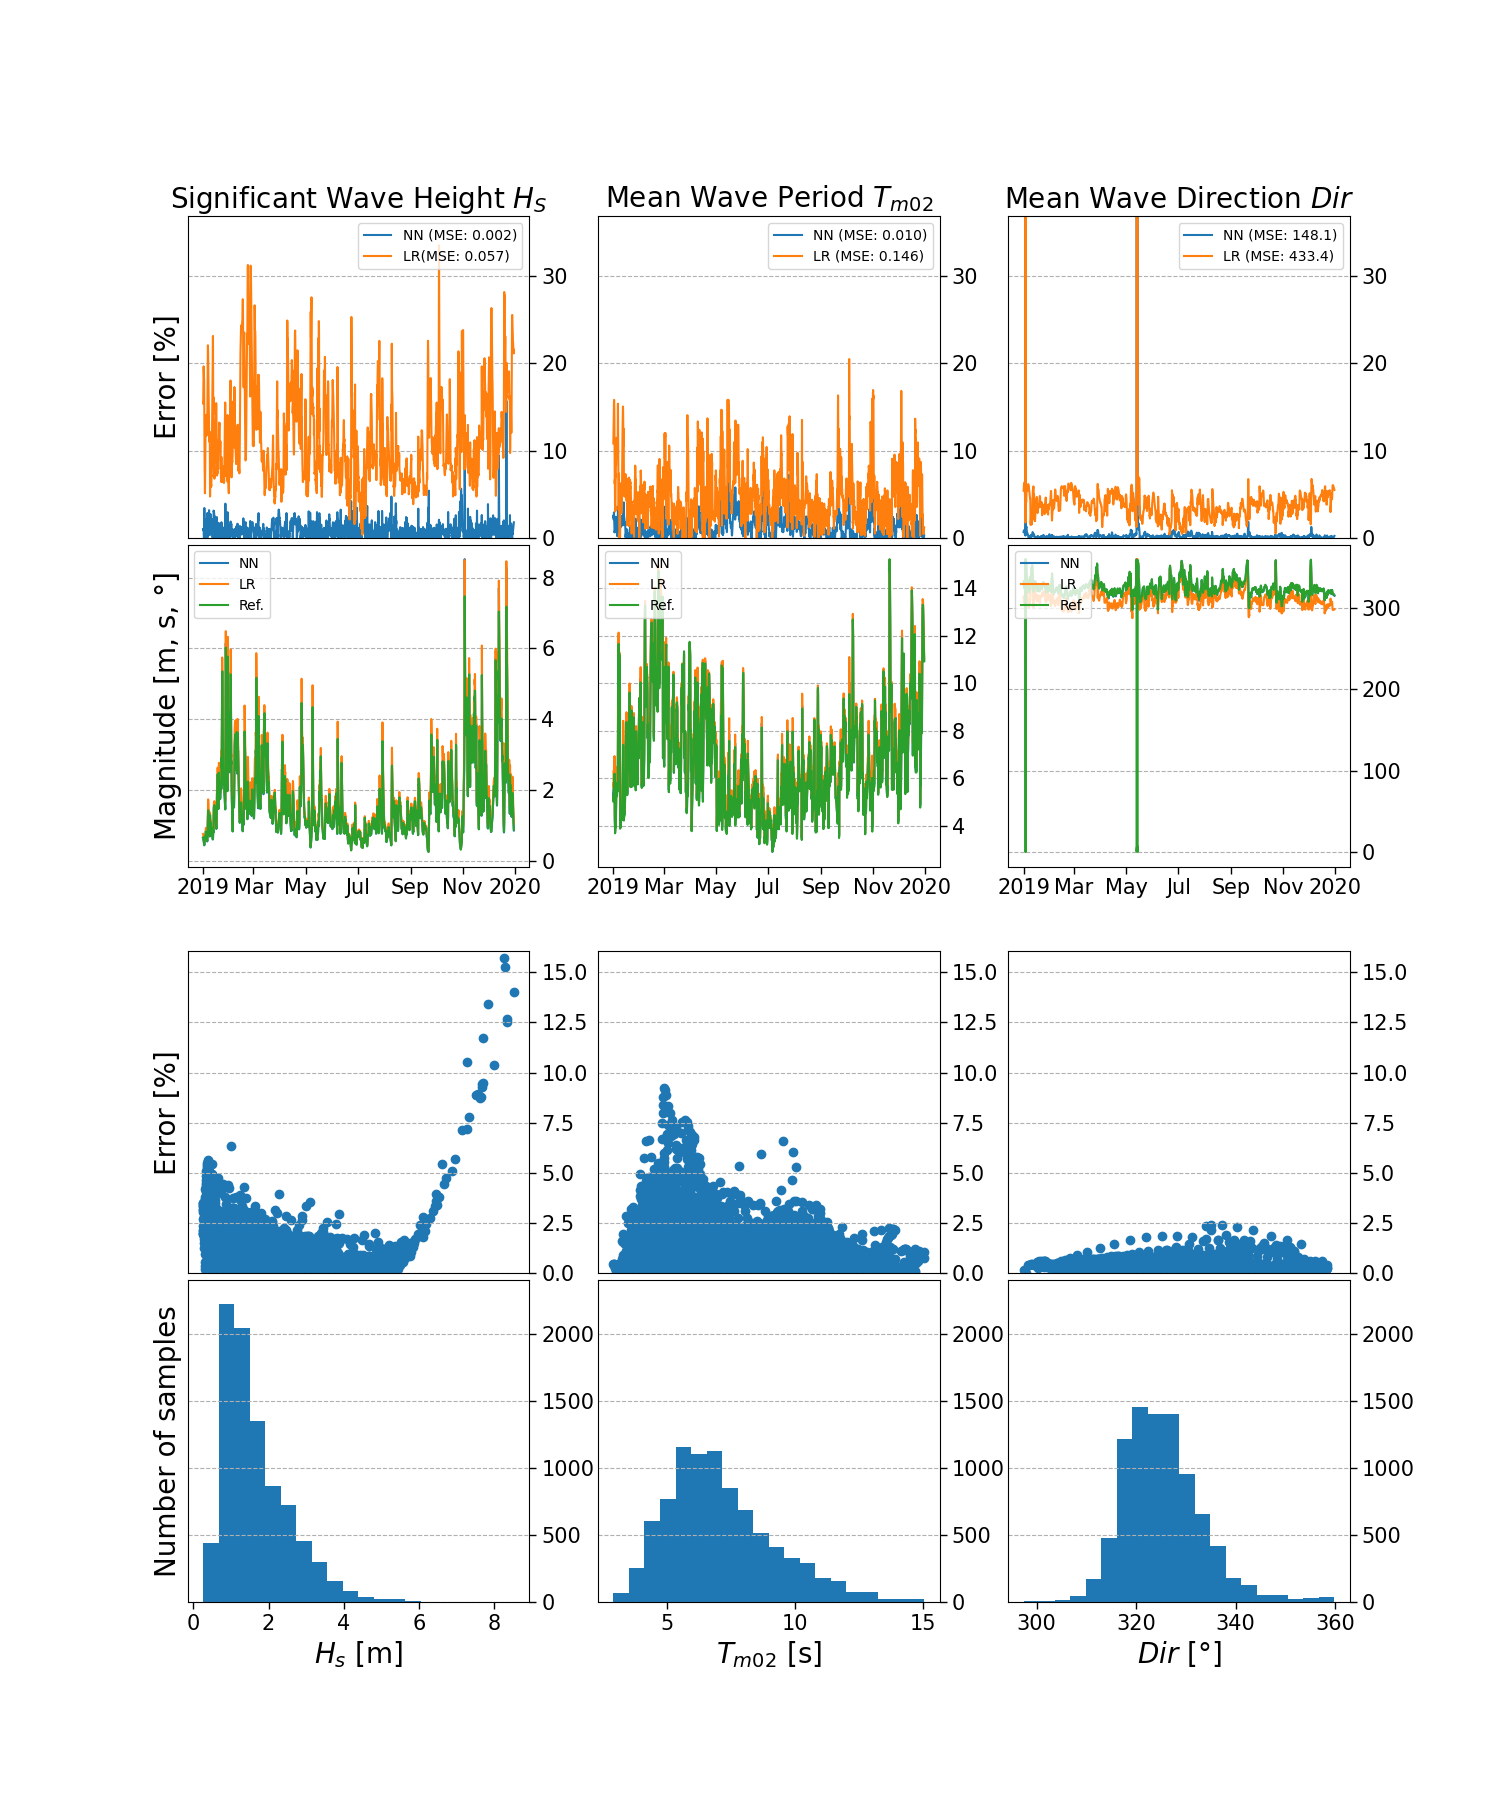

In [8]:
# Some plotting constants for the ticks
LABELSIZE = 15
LENGTH = 5.0
WIDTH= 1.0

# Maximal histogram value
hist_y = 2400

fig = plt.figure(figsize=(15,18))
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)

# To plot the right test data section, given that the sample number includes the training data
n1 = nmin - sample_start
n2 = nmax - sample_start

# Split the plot in two main sections with subgrids
gs = GridSpec(4, 3, hspace=0.3)

subg1 = gs[0:2,:].subgridspec(2, 3, hspace=0.02)
subg2 = gs[2:4,:].subgridspec(2, 3, hspace=0.02)

plt.rc('axes', labelsize=20) 
plt.rc('axes', titlesize=20)

############################# First Column
lower = np.nanmin(prediction[0])
upper = np.nanmax(prediction[0])

ax1 = fig.add_subplot(subg1[0,0])

ax1.xaxis.set_major_locator(locator)
ax1.xaxis.set_major_formatter(formatter)
ax1.set_ylim(0, np.max(error_LR[0][n1:n2]) + 0.1*np.max(error_LR[0][n1:n2]))
ax1.plot(dates[nmin:nmax], error[0][n1:n2], label="NN (MSE: {:.3f})".format(mse[0]))
ax1.plot(dates[nmin:nmax], error_LR[0][n1:n2], label="LR(MSE: {:.3f})".format(mse_LR[0]))
#ax1.plot(dates[nmin:nmax], (int_arr[0]-reference[0])**2, label="Bicubic Interpolation (MSE: {:.3f})".format(mse_int[0]))
ax1.set_ylabel("Error [%]")
ax1.grid(True, axis="y", ls="--")
ax1.legend(loc="upper right")
ax1.set_title(r"Significant Wave Height $H_S$")
ax1.tick_params(axis='both', left=False, top=False, right=True, bottom=False,
                     labelleft=False, labeltop=False, labelright=True, labelbottom=False)
ax1.tick_params(labelsize=LABELSIZE, length=LENGTH, width=WIDTH)


ax2 = fig.add_subplot(subg1[1,0])

ax2.xaxis.set_major_locator(locator)
ax2.xaxis.set_major_formatter(formatter)
ax2.plot(dates[nmin:nmax], prediction[0][n1:n2], label="NN")
ax2.plot(dates[nmin:nmax], LR_reference[0][n1:n2], label="LR")
ax2.plot(dates[nmin:nmax], reference[0][n1:n2], label="Ref.")
ax2.grid(True, axis="y", ls="--")
ax2.set_ylabel("Magnitude [m, s, °]")
ax2.legend(loc="upper left")
ax2.tick_params(axis='both', left=False, top=False, right=True, bottom=True,
                     labelleft=False, labeltop=False, labelright=True, labelbottom=True)
ax2.tick_params(labelsize=LABELSIZE, length=LENGTH, width=WIDTH)


ax3 = fig.add_subplot(subg2[0,0])

ax3.set_ylabel("Error [%]")
ax3.scatter(prediction[0], error[0])
ax3.set_ylim(0, np.max(error[0]) + 0.02*np.max(error[0]))
ax3.grid(True, axis="y", ls="--")
ax3.tick_params(axis='both', left=False, top=False, right=True, bottom=False,
                     labelleft=False, labeltop=False, labelright=True, labelbottom=False)
ax3.tick_params(labelsize=LABELSIZE, length=LENGTH, width=WIDTH)


ax4 = fig.add_subplot(subg2[1,0])

ax4.set_ylabel("Number of samples")
ax4.set_xlabel(r"$H_s$ [m]")
ax4.set_ylim(0, hist_y)
ax4.hist(ref_training[0], 20, label="Predictions", range=(lower, upper))
ax4.grid(True, axis="y", ls="--")
ax4.tick_params(axis='both', left=False, top=False, right=True, bottom=True,
                     labelleft=False, labeltop=False, labelright=True, labelbottom=True)
ax4.tick_params(labelsize=LABELSIZE, length=LENGTH, width=WIDTH)


############################ Second Column
lower = np.min(prediction[1])
upper = np.max(prediction[1])

ax5 = fig.add_subplot(subg1[0,1])

ax5.xaxis.set_major_locator(locator)
ax5.xaxis.set_major_formatter(formatter)
ax5.set_ylim(0, np.max(error_LR[0][n1:n2]) + 0.1*np.max(error_LR[0][n1:n2]))
ax5.plot(dates[nmin:nmax], error[1][n1:n2], label="NN (MSE: {:.3f})".format(mse[1]))
ax5.plot(dates[nmin:nmax], error_LR[1][n1:n2], label="LR (MSE: {:.3f})".format(mse_LR[1]))
#ax5.plot(dates[nmin:nmax], (int_arr[1]-reference[1])**2, label="Bicubic Interpolation (MSE: {:.3f})".format(mse_int[1]))
ax5.grid(True, axis="y", ls="--")
ax5.legend()
ax5.set_title(r"Mean Wave Period $T_{m02}$")
ax5.tick_params(axis='both', left=False, top=False, right=True, bottom=False,
                     labelleft=False, labeltop=False, labelright=True, labelbottom=False)
ax5.tick_params(labelsize=LABELSIZE, length=LENGTH, width=WIDTH)


ax6 = fig.add_subplot(subg1[1,1])

ax6.xaxis.set_major_locator(locator)
ax6.xaxis.set_major_formatter(formatter)
ax6.plot(dates[nmin:nmax], prediction[1][n1:n2], label="NN")
ax6.plot(dates[nmin:nmax], LR_reference[1][n1:n2], label="LR")
ax6.plot(dates[nmin:nmax], reference[1][n1:n2], label="Ref.")
ax6.grid(True, axis="y", ls="--")
ax6.legend(loc="upper left")
ax6.tick_params(axis='both', left=False, top=False, right=True, bottom=True,
                     labelleft=False, labeltop=False, labelright=True, labelbottom=True)
ax6.tick_params(labelsize=LABELSIZE, length=LENGTH, width=WIDTH)


ax7 = fig.add_subplot(subg2[0,1])

ax7.scatter(prediction[1], error[1])
ax7.set_ylim(0, np.max(error[0]) + 0.02*np.max(error[0]))
ax7.grid(True, axis="y", ls="--")
ax7.tick_params(axis='both', left=False, top=False, right=True, bottom=False,
                     labelleft=False, labeltop=False, labelright=True, labelbottom=False)
ax7.tick_params(labelsize=LABELSIZE, length=LENGTH, width=WIDTH)


ax8 = fig.add_subplot(subg2[1,1])

ax8.set_xlabel(r"$T_{m02}$ [s]")
ax8.set_ylim(0, hist_y)
ax8.hist(ref_training[1], 20, label="Predictions", range=(lower, upper))
ax8.grid(True, axis="y", ls="--")
ax8.tick_params(axis='both', left=False, top=False, right=True, bottom=True,
                     labelleft=False, labeltop=False, labelright=True, labelbottom=True)
ax8.tick_params(labelsize=LABELSIZE, length=LENGTH, width=WIDTH)


############################ Third Column
lower = np.nanmin(prediction[2])
upper = np.nanmax(prediction[2])

ax9 = fig.add_subplot(subg1[0,2])

ax9.xaxis.set_major_locator(locator)
ax9.xaxis.set_major_formatter(formatter)
ax9.set_ylim(0, np.max(error_LR[0][n1:n2]) + 0.1*np.max(error_LR[0][n1:n2]))
ax9.plot(dates[nmin:nmax], error[2][n1:n2], label="NN (MSE: {:.1f})".format(mse[2]))
ax9.plot(dates[nmin:nmax], error_LR[2][n1:n2], label="LR (MSE: {:.1f})".format(mse_LR[2]))
#ax9.plot(dates[nmin:nmax], (int_arr[2]-reference[2])**2, label="Bicubic Interpolation (MSE: {:.3f})".format(mse_int[2]))
ax9.grid(True, axis="y", ls="--")
ax9.legend()
ax9.set_title(r"Mean Wave Direction $Dir$")
ax9.tick_params(axis='both', left=False, top=False, right=True, bottom=False,
                     labelleft=False, labeltop=False, labelright=True, labelbottom=False)
ax9.tick_params(labelsize=LABELSIZE, length=LENGTH, width=WIDTH)


ax10 = fig.add_subplot(subg1[1,2])

ax10.xaxis.set_major_locator(locator)
ax10.xaxis.set_major_formatter(formatter)
ax10.plot(dates[nmin:nmax], prediction[2][n1:n2], label="NN")
ax10.plot(dates[nmin:nmax], LR_reference[2][n1:n2], label="LR")
ax10.plot(dates[nmin:nmax], reference[2][n1:n2], label="Ref.")
ax10.grid(True, axis="y", ls="--")
ax10.legend(loc="upper left")
ax10.tick_params(axis='both', left=False, top=False, right=True, bottom=True,
                     labelleft=False, labeltop=False, labelright=True, labelbottom=True)
ax10.tick_params(labelsize=LABELSIZE, length=LENGTH, width=WIDTH)


ax11 = fig.add_subplot(subg2[0,2])


ax11.scatter(prediction[2], error[2])
ax11.set_ylim(0, np.max(error[0]) + 0.02*np.max(error[0]))
ax11.grid(True, axis="y", ls="--")
ax11.tick_params(axis='both', left=False, top=False, right=True, bottom=False,
                     labelleft=False, labeltop=False, labelright=True, labelbottom=False)
ax11.tick_params(labelsize=LABELSIZE, length=LENGTH, width=WIDTH)


ax12 = fig.add_subplot(subg2[1,2])

ax12.set_xlabel(r"$Dir$ [°]")
ax12.set_ylim(0, hist_y)
ax12.hist(ref_training[2], 20, label="Predictions", range=(lower, upper))
ax12.grid(True, axis="y", ls="--")
ax12.tick_params(axis='both', left=False, top=False, right=True, bottom=True,
                     labelleft=False, labeltop=False, labelright=True, labelbottom=True)
ax12.tick_params(labelsize=LABELSIZE, length=LENGTH, width=WIDTH)






plt.tight_layout()

#plt.suptitle(title)


if save:
    if not os.path.isdir(fdir):
        os.makedirs(fdir)
    plt.savefig(os.path.join(fdir, fname))
                         
plt.show()

In [25]:
error[0][8524]

15.7218617284439

In [26]:
8761+8524

17285

In [13]:
error[0].size

8736